In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import DataFrame,Series
%matplotlib inline

In [193]:
data = pd.read_csv("Data.csv")

In [194]:
#Binning:
def binning(col, cut_points, labels=None):
  #Define min and max values:
  minval = col.min()
  maxval = col.max()

  #create list by adding min and max to cut_points
  break_points = [minval] + cut_points + [maxval]

  #if no labels provided, use default labels 0 ... (n-1)
  if not labels:
    labels = range(len(cut_points)+1)

  #Binning using cut function of pandas
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

#Binning age:
cut_points = [90,180,270]
labels = ["SW","SE","NE","NW"]
data["Wind_Origination"] = binning(data["Direction_Of_Wind"], cut_points, labels)
#print(pd.value_counts(data["MaxSpeed_Bin"], sort=False))
#data["Wind_Origination"] = data["Wind_Origination"].apply(lambda x: 'W' if x=="W2" else x)

In [195]:
data["Mean_Park_Month"]=data.groupby(["Park_ID","Month"]).transform(lambda x: x.mean()).Footfall

In [196]:
train = data.loc[data["Train"]==True,]
test = data.loc[data["Train"]==False]

In [4]:
def calc_anova(dataframe,x,target):
    grand_mean = dataframe[target].mean()
    categories = dataframe[x].value_counts()
    groups = dataframe.groupby(x)[target]
    ss_between = (((groups.mean()-grand_mean)**2)*groups.count()).sum()
    df_between = len(categories)-1
    ms_between = ss_between/df_between
    ss_within = (groups.var()*(groups.count()-1)).sum()
    df_within = dataframe.shape[0]-len(categories)
    ms_within = ss_within/df_within
    F = ms_between/ms_within
    eeta = ss_between/(ss_between+ss_within)
    print(F)
    print("eeta = ",eeta)

In [84]:
calc_anova(train,"Day","Footfall")

6.188004398452261
eeta =  0.00032406658783473686


In [86]:
calc_anova(train,"Location_Type","Footfall")

0.8870545076260429
eeta =  2.3233960741339433e-05


In [87]:
calc_anova(train,"Year","Footfall")

78.51798339842898
eeta =  0.00748498651728068


In [89]:
calc_anova(train,"Month","Footfall")

3762.9761691562603
eeta =  0.2654746501542638


In [90]:
calc_anova(train,"Park_ID","Footfall")

13.072261716343013
eeta =  0.0030727749051345935


In [91]:
calc_anova(train,"Weekday","Footfall")

0.0021047365012230846
eeta =  1.8376039729924502e-08


In [97]:
calc_anova(train,"Season","Footfall")

11027.768743729015
eeta =  0.2241138451986763


In [200]:
data2.columns

Index(['season_Spring', 'season_Summer', 'season_Winter', 'weekday_1',
       'wind_SE', 'wind_NE', 'wind_NW', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12'],
      dtype='object')

In [197]:
#loc = pd.get_dummies(data["Location_Type"],drop_first=True,prefix="loc")
#year = pd.get_dummies(data["Year"],drop_first=True,prefix="year")
month = pd.get_dummies(data["Month"],drop_first=True,prefix="month")
season = pd.get_dummies(data["Season"],drop_first=True,prefix="season")
#day = pd.get_dummies(data["Day"],drop_first=True,prefix="day")
weekday = pd.get_dummies(data["Weekday"],drop_first=True,prefix="weekday")
#park = pd.get_dummies(data["Park_ID"],drop_first=True,prefix="park")
wind = pd.get_dummies(data["Wind_Origination"],drop_first=True,prefix="wind")

In [201]:
data2 = pd.concat([data,season,weekday,wind,month],axis=1)

In [202]:
data2.drop(["Season","Day","Weekday","Location_Type","Year","Wind_Origination","Date","ID","Park_ID","Month","Train"],inplace=True,axis=1)

In [203]:
train2 = data2.loc[data["Train"]==True,]
test2 = data2.loc[data["Train"]==False,]

In [110]:
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize

In [207]:
features = list(train2.columns)
features.remove("Footfall")

## GradientBoosting

In [275]:
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
train = train2[features]
target = train2["Footfall"]
test = test2[features]

In [227]:
def modelfit(alg,dtrain,predictors,test,performCV=True,printFeaturesImportance=True,cv_folds=5):
    #create training and validation sets
    #X_train, X_test, Y_train, Y_test = train_test_split(dtrain[predictors],target,test_size=.4)
    
    #fit the algorithm on data
    alg.fit(dtrain[predictors],target)
    
    #predict on training set
    dtrain_prediction = alg.predict(dtrain[predictors])
    
    #predict on test set
    y = alg.predict(test)
        
    #cross validation score
    if performCV:
        cv_score = cross_validation.cross_val_score(alg,dtrain[predictors],target,cv=cv_folds,scoring="r2")
        
    #Print model score
    print("\n/MODEL REPORT")
    print("Accuracy : %.4g" % metrics.r2_score(target.values, dtrain_prediction))
    
    if performCV:
        print("CV score :Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Print features importance:
    if printFeaturesImportance:
        feat_imp=pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    return y


/MODEL REPORT
Accuracy : 0.5719
CV score :Mean - 0.5575159 | Std - 0.02828942 | Min - 0.5023192 | Max - 0.5814274


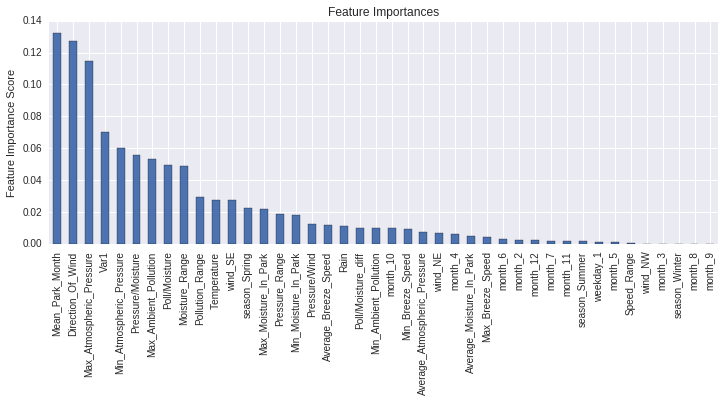

In [228]:
gbm0 = GradientBoostingRegressor(random_state=10)
modelfit(gbm0, train, features)

In [250]:
param_test1 = [{'n_estimators':[130,150,170,190,210,230]}]
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=1, min_samples_split=1500,min_samples_leaf=500,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train,target)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=1.2, loss='ls',
             max_depth=8, max_features='sqrt', max_leaf_nodes=None,
             min_samples_leaf=500, min_samples_split=1500,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=10, subsample=0.8, verbose=0,
             warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid=[{'n_estimators': [40, 45, 50]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [251]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -27906.42022, std: 1531.08254, params: {'n_estimators': 40},
  mean: -27694.58730, std: 1560.90897, params: {'n_estimators': 45},
  mean: -27503.09509, std: 1646.81484, params: {'n_estimators': 50}],
 {'n_estimators': 50},
 -27503.095091371641)

In [259]:
param_test2 = [{'max_depth':[8,7,9], 'min_samples_split':[1000,1100,1200]}]
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=1, n_estimators=120, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train,target)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=1, loss='ls',
             max_depth=3, max_features='sqrt', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=120,
             presort='auto', random_state=10, subsample=0.8, verbose=0,
             warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid=[{'max_depth': [8, 7, 9], 'min_samples_split': [1000, 1100, 1200]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [260]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: -24048.72327, std: 1970.60462, params: {'max_depth': 8, 'min_samples_split': 1000},
  mean: -23896.48413, std: 2152.88770, params: {'max_depth': 8, 'min_samples_split': 1100},
  mean: -24135.22723, std: 1989.33872, params: {'max_depth': 8, 'min_samples_split': 1200},
  mean: -23649.64520, std: 1881.81611, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: -23504.37671, std: 1755.84913, params: {'max_depth': 7, 'min_samples_split': 1100},
  mean: -23753.49669, std: 1702.90985, params: {'max_depth': 7, 'min_samples_split': 1200},
  mean: -24466.05153, std: 2000.71401, params: {'max_depth': 9, 'min_samples_split': 1000},
  mean: -24126.01917, std: 2147.51052, params: {'max_depth': 9, 'min_samples_split': 1100},
  mean: -24067.34987, std: 2369.79351, params: {'max_depth': 9, 'min_samples_split': 1200}],
 {'max_depth': 7, 'min_samples_split': 1100},
 -23504.376714328278)

In [258]:
param_test3 = [{'min_samples_leaf':[550,600,650]}]
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=1, n_estimators=120,max_depth=7,min_samples_split=1100,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train,target)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -23240.16634, std: 1925.25679, params: {'min_samples_leaf': 550},
  mean: -22865.11293, std: 1637.03031, params: {'min_samples_leaf': 600},
  mean: -23262.88498, std: 1535.47492, params: {'min_samples_leaf': 650}],
 {'min_samples_leaf': 600},
 -22865.112928975112)

In [263]:
param_test4 = [{'max_features':[7,9,11,13,15,17,19]}]
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=1, n_estimators=120,max_depth=7,min_samples_split=1100, min_samples_leaf=600, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train,target)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -22957.61461, std: 1510.21801, params: {'max_features': 7},
  mean: -22595.19648, std: 1672.37661, params: {'max_features': 9},
  mean: -22059.88306, std: 1662.80220, params: {'max_features': 11},
  mean: -22231.97625, std: 1460.53397, params: {'max_features': 13},
  mean: -21917.74805, std: 1768.18079, params: {'max_features': 15},
  mean: -21533.59915, std: 1796.32015, params: {'max_features': 17},
  mean: -21671.56226, std: 1631.55423, params: {'max_features': 19}],
 {'max_features': 17},
 -21533.599153197119)

In [268]:
param_test5 = [{'subsample':[.9]}]
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=1, n_estimators=120,max_depth=7,min_samples_split=1100, min_samples_leaf=600, random_state=10,max_features=7),
param_grid = param_test5, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train,target)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: -22132.62570, std: 1784.98408, params: {'subsample': 0.95}],
 {'subsample': 0.95},
 -22132.625699535052)

In [278]:
gbm_tuned_2 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1500,max_depth=9, min_samples_split=1100,min_samples_leaf=600, subsample=1, random_state=10, max_features=7)
modelfit(gbm_tuned_2, train, features)

In [279]:
gbm_tuned_2.fit(train,target)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=9, max_features=7, max_leaf_nodes=None,
             min_samples_leaf=600, min_samples_split=1100,
             min_weight_fraction_leaf=0.0, n_estimators=1500,
             presort='auto', random_state=10, subsample=1, verbose=0,
             warm_start=False)

In [287]:
prediction = Series(gbm_tuned_2.predict(test),name="Footfall")
out = pd.concat([data.loc[data["Train"]==False,"ID"].reset_index(drop=True),prediction],axis=1)
out.to_csv("output.csv")

In [282]:
gbm0.predict(test)

array([ 1096.6195426 ,  1071.27154742,  1064.02166035, ...,  1011.04204909,
         949.26236066,  1122.43767416])

In [133]:
X_train, X_test, y_train, y_test = train_test_split(train2[features],train2.Footfall,test_size=.3)
#X_data = pd.concat([X_train,y_train],axis=1)
#X_train["Mean_Park_Month"]=X_data.groupby(["Park_ID","Month"]).transform(lambda x: x.mean()).Footfall
#X_test["Mean_Park_Month"] = X_data.groupby(["Park_ID","Month"]).transform(lambda x: x.mean()).Footfall
X_train = DataFrame(normalize(X_train),columns=features)
X_test = DataFrame(normalize(X_test),columns=features)

In [134]:
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [135]:
cv = KFold(len(X_train),n_folds=10,shuffle=True)

In [140]:
model = RandomForestRegressor(n_estimators=100,min_samples_split=100,min_samples_leaf=50)

In [331]:
results=[]
for traincv,testcv in cv:
    probas = model.fit(X_train.ix[traincv],y_train.ix[traincv]).predict(X_train.ix[testcv])
    results.append(mean_squared_error(probas,y_train.ix[testcv]))
                       

In [64]:
from sklearn.linear_model import LinearRegression

In [69]:
lr = LinearRegression()

In [70]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [73]:
Series(lr.coef_,index=X_train.columns).sort_values(ascending=False)

Mean_Park_Month                 1.000000e+00
day_5                           2.540360e-09
day_6                           2.349156e-09
weekday_1                       2.273210e-09
month_9                         1.627653e-09
season_Summer                   1.522475e-09
month_10                        1.277765e-09
park_34                         1.144080e-09
loc_3                           1.074015e-09
park_15                         1.064514e-09
park_24                         1.060617e-09
season_Spring                   1.021760e-09
park_16                         1.009040e-09
month_11                        9.740780e-10
loc_2                           9.356544e-10
loc_4                           8.748065e-10
month_7                         7.907109e-10
season_Winter                   7.389953e-10
Rain                            7.285751e-10
Pressure/Moisture               7.155588e-10
month_5                         6.261183e-10
park_14                         6.051807e-10
Average_At

In [200]:
from sklearn.preprocessing import scale

In [220]:
len(features)

100

In [272]:
pd.isnull(df.set_value(0,"Distance",np.nan)).sum()

Distance    1
Length      0
dtype: int64

In [303]:
assert not np.any(np.isnan(y_train))
assert np.all(np.isfinite(y_train))
assert np.all(y_train <= np.finfo('float32').max)
assert np.all(y_train >= np.finfo('float32').min)

In [186]:
del X_train["Mean_Park_Month"]

In [187]:
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=50,
           min_samples_split=100, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [142]:
np.sqrt(sum(((Series(model.predict(X_test),name="Footfall")-y_test)**2)/len(y_test)))

150.40074750138882

In [190]:
#del test2["Mean_Park_Month"]
features.remove("Mean_Park_Month")
Y = Series(model.predict(DataFrame(normalize(test2[features]),columns=features)),name="Footfall")

In [191]:
out = pd.concat([test["ID"].reset_index(drop=True),Y],axis=1)

In [192]:
out.to_csv("rf3.csv")

In [184]:
out

,ID,Footfall
0,3725712,1114.161770
1,3725812,1116.893837
2,3725912,1076.406399
3,3726012,1075.109435
4,3726112,1187.789280
5,3726212,1250.447323
6,3726312,1249.225618
7,3726412,1251.500306
8,3726512,1283.727431
9,3726612,1221.315207


In [143]:
Series(model.feature_importances_,index=X_train.columns).sort_values(ascending=False)

Mean_Park_Month                 0.430897
Moisture_Range                  0.108458
Direction_Of_Wind               0.079608
Min_Moisture_In_Park            0.046023
Pressure/Moisture               0.032158
Max_Ambient_Pollution           0.030920
Max_Atmospheric_Pressure        0.025785
Temperature                     0.019587
Var1                            0.017692
Average_Moisture_In_Park        0.016952
Min_Breeze_Speed                0.016949
Speed_Range                     0.016483
Average_Atmospheric_Pressure    0.014254
Max_Moisture_In_Park            0.010914
Min_Ambient_Pollution           0.008856
Min_Atmospheric_Pressure        0.007857
year_2000                       0.007771
Pressure/Wind                   0.007490
Pollution_Range                 0.007433
Poll/Moisture                   0.007239
Pressure_Range                  0.006145
Max_Breeze_Speed                0.005493
wind_SE                         0.005375
year_1996                       0.004919
month_3         

In [48]:
features = list(Series(model.feature_importances_,index=X_train.columns)[Series(model.feature_importances_,index=X_train.columns).sort_values(ascending=False)>0].index)

In [54]:
features.remove("loc_3")
features.remove("season_Spring")
features.remove("season_Winter")
features.remove("weekday_1")
features.remove("wind_NE")
features.remove("Moisture_Range")
features.remove("Pollution_Range")
features.remove("Speed_Range")
features.remove("Pressure_Range")
features.remove("Mean_Park_Month")

In [50]:
features.extend(["Location_Type","Season","Weekday","Wind_Origination"])

In [59]:
'''
#Binning:
def binning(col, cut_points, labels=None):
  #Define min and max values:
  minval = col.min()
  maxval = col.max()

  #create list by adding min and max to cut_points
  break_points = [minval] + cut_points + [maxval]

  #if no labels provided, use default labels 0 ... (n-1)
  if not labels:
    labels = range(len(cut_points)+1)

  #Binning using cut function of pandas
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

#Binning age:
cut_points = [45,135,225,315]
labels = ["W","N","E","S","W2"]
data["Wind_Origination"] = binning(data["Direction_Of_Wind"], cut_points, labels)
#print(pd.value_counts(data["MaxSpeed_Bin"], sort=False))
data["Wind_Origination"] = data["Wind_Origination"].apply(lambda x: 'W' if x=="W2" else x)
'''
1

In [ ]:
from sklearn.ensemble import GradientBoostingRegressorgressor  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

NameError: name 'alg' is not defined

In [288]:
import pandas as pd
import numpy as np 
from pandas import DataFrame,Series


#read the files
train = pd.read_csv("Train_xyqdbho.csv")
test = pd.read_csv("Test_pyI9Owa.csv")

#merging test and train datasets
train["Train"] = True
test["Train"] = False
data=pd.concat([train,test],axis=0)

#converting Date to datetime format
data["Date"] = data.Date.apply(lambda x:pd.to_datetime(x))
data["Day"] = data.Date.dt.weekday
#weekday or weekend
data["Weekday"] = data["Day"].apply(lambda x: 1 if x in range(0,5) else 0)
data["Year"] = data.Date.dt.year
data["Month"] = data.Date.dt.month


#missing value treatment
missing = list(pd.isnull(data).sum().loc[pd.isnull(data).sum()>0,].index)
for i in missing:
    data[i] = data.groupby("Date").transform(lambda x: x.fillna(x.mean()))[i]



#modelling
month = pd.get_dummies(data["Month"],drop_first=True,prefix="month")
weekday = pd.get_dummies(data["Weekday"],drop_first=True,prefix="weekday")
loc = pd.get_dummies(data["Location_Type"],drop_first=True,prefix="loc")
data2 = pd.concat([data,weekday,month,loc],axis=1)
data2.drop(["Day","Weekday","Location_Type","Year","Date","ID","Park_ID","Month","Train"],inplace=True,axis=1)
train2 = data2.loc[data["Train"]==True,]
test2 = data2.loc[data["Train"]==False,]
features = list(train2.columns)
features.remove("Footfall")
train = train2[features]
target = train2["Footfall"]
test = test2[features]

from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1500,max_depth=9, min_samples_split=1100,min_samples_leaf=600, subsample=1, random_state=10, max_features=7)
gbm.fit(train,target)
prediction = Series(gbm.predict(test),name="Footfall")
out = pd.concat([data.loc[data["Train"]==False,"ID"].reset_index(drop=True),prediction],axis=1)
out.to_csv("outputs.csv")